# Multi Axion System

In [29]:
%matplotlib inline

In [30]:
%run observables.py
%run multi_axion.py
%run analysis_tools.py
%run plot_tools.py

def sim_multi_axion(Q, Lambda, theta_is, velocities, H_inf, Gamma_inf, tmax_axion):
    energy_scale, conv_factor, rho_R_init, rho_inf_init, scale, tmax_inf, red_chem_pots_init = \
        init_system(H_inf, Gamma_inf, (Q, Lambda), multi_axion_field, tmax_axion)
    rh_sol, T_and_H_fn, T_and_H_and_T_dot_fn = decay_process.solve(tmax_inf, rho_R_init, rho_inf_init, scale, Gamma_inf)
    
    u0 = np.hstack([theta_is, velocities])
    axsol = multi_axion_field.solve(u0, (Q, Lambda), tmax_axion, T_and_H_fn, Gamma_inf)
    
    ts = np.geomspace(axsol.t[1], axsol.t[-1], 500)
    theta1s, theta2s, theta1_dots, theta2_dots  = axsol.sol(ts)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(ts, theta1s, label=canonical_names[0])
    ax1.plot(ts, theta2s, label=canonical_names[1])
    ax1.set_xscale("log")
    ax1.set_xlabel(r"$m_a \cdot t$")
    ax1.legend()
    ax2.plot(ts, theta1_dots, label=canonical_names[2])
    ax2.plot(ts, theta2_dots, label=canonical_names[3])
    ax2.set_xscale("log")
    ax2.set_xlabel(r"$m_a \cdot t$")
    ax2.legend()

    interval = np.pi / 8 
    def calc_range(x): return np.linspace(np.floor(np.min(x) / interval) * interval, np.ceil(np.max(x) / interval) * interval, 100)
    range1, range2 = calc_range(theta1s), calc_range(theta2s)
    V = np.array([[multi_axion_field.calc_V([t1, t2], Q, Lambda) for t1 in range1] for t2 in range2])

    plt.figure(figsize=(6,5))
    plt.contourf(range1, range2, V, levels=15)
    plt.plot(theta1s, theta2s, color="red")
    plt.plot([theta1s[0]], [theta2s[0]], "bo")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.colorbar(label=r"$V(\theta_1, \theta_2)$")
    
    return theta1s, theta2s, theta1_dots, theta2_dots

<Figure size 432x288 with 0 Axes>

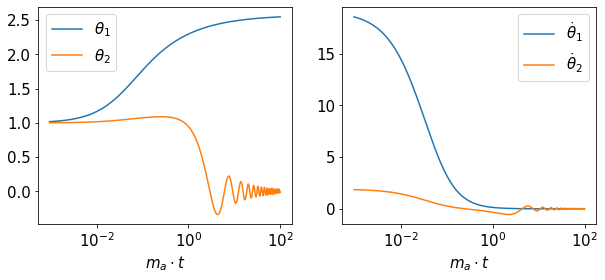

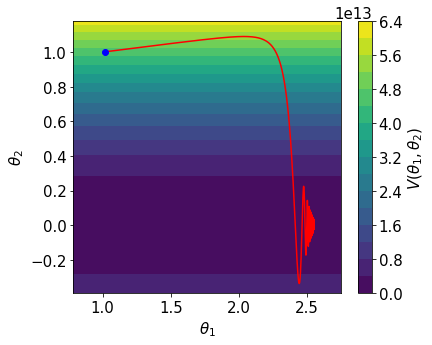

In [60]:
M = 1e7
Gamma_inf = H_inf = 1e8
tmax = 1e2

theta_i = 1
v = 20* np.sqrt(2*(1 - np.cos(theta_i)))
beta = 0.1
alpha = 0
lambda1 = 10.0
lambda2 = 1.0
R = 0.0
g = 1e-8

Q = np.array([[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.cos(alpha)]]) @ np.diag([lambda1, lambda2]) @ np.array([[1, R], [0, 1]])
theta1s, theta2s, theta1_dots, theta2_dots = sim_multi_axion(Q, M**2 * np.array([g, 1]), [theta_i, theta_i], 
                                            v * np.array([np.cos(beta), np.sin(beta)]), H_inf, Gamma_inf, tmax)